Elapsed time: 0.00581812858581543


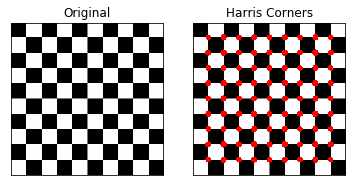

In [4]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

q1_img1_path = "/Users/Will/Desktop/q1_board.jpg"

q1_img1 = cv2.imread(q1_img1_path)
q1_img2 = q1_img1.copy()
q1_img2_gray = cv2.cvtColor(q1_img2, cv2.COLOR_BGR2GRAY) #convert to gray-scale

H = np.array([(1,1), (1,1)])
height, width = q1_img2_gray.shape

#Compute Image Derivatives
I_x = cv2.Sobel(q1_img2_gray, cv2.CV_64F, 1, 0, ksize=5)
I_y = cv2.Sobel(q1_img2_gray, cv2.CV_64F, 0, 1, ksize=5)
I_xy = I_x*I_y

#Applying Guassian Blur
G_x = img = cv2.GaussianBlur(I_x**2, (15, 15), 0)
G_y = img = cv2.GaussianBlur(I_y**2, (15, 15), 0)
G_xy = img = cv2.GaussianBlur(I_xy, (15, 15), 0)

t0 = time.time()
R = q1_img2_gray.copy()

#Harris Operator
R = (G_x*G_y-G_xy**2)-0.04*(G_x+G_y)**2

print("Elapsed time:", time.time() - t0)

#normalize the image
cv2.normalize(R, R, 0, 1, cv2.NORM_MINMAX)
thres = 0.7

# list all points higher than threshold
loc = np.where(R >= thres)

# loop though points
for pt in zip(*loc[::-1]):
    # draw filled circle on each point
    cv2.circle(q1_img2, pt, 10, (0, 0,255), -1)

#saving the output image to destination
cv2.imwrite('/Users/Will/Desktop/Assign2/q1_harrisCorners.jpg', q1_img2)

#convert the image to RGB
q1_img2 = cv2.cvtColor(q1_img2, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(q1_img1, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(q1_img2, cmap="gray")
plt.title("Harris Corners"), plt.xticks([]), plt.yticks([])
plt.show()

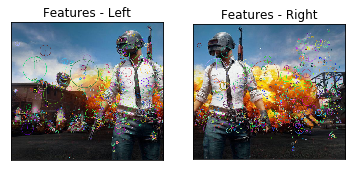

In [8]:
import random
q2_img1_left_path = "/Users/Will/Desktop/pubg_left.jpeg"
q2_img1_right_path = "/Users/Will/Desktop/pubg_right.jpeg"

q2_img1_left = cv2.imread(q2_img1_left_path) 
img_disp_left = q2_img1_left.copy()
q2_img2_left = q2_img1_left.copy()

q2_img1_right = cv2.imread(q2_img1_right_path)
img_disp_right = q2_img1_right.copy()
q2_img2_right = q2_img1_right.copy()

###########################################   PART 1   ########################################### 
# Create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Detect SIFT features, with no masks
kp_left,des_left = sift.detectAndCompute(q2_img1_left,None)
kp_right,des_right = sift.detectAndCompute(q2_img1_right,None)

# draw the keypoints
cv2.drawKeypoints(q2_img1_left, kp_left, img_disp_left, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(q2_img1_right, kp_left, img_disp_right, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#saving the output image to destination
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_part1_left.jpg', img_disp_left)
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_part1_right.jpg', img_disp_right)

# convert from BGR to RGB for displaying
img_disp_left = cv2.cvtColor(img_disp_left, cv2.COLOR_BGR2RGB)
img_disp_right = cv2.cvtColor(img_disp_right, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(img_disp_left, cmap="gray")
plt.title("Features - Left"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_disp_right, cmap="gray")
plt.title("Features - Right"), plt.xticks([]), plt.yticks([])
plt.show()

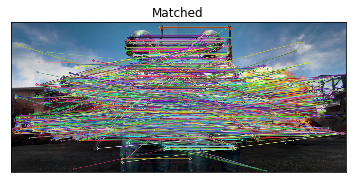

In [9]:
###########################################   PART 2   ########################################### 
#Matching feature descriptors 
bf = cv2.BFMatcher()
matches = bf.knnMatch(des_left, des_right, k = 2)
matched = []

#append keypoints into array with matched descriptor
for m,n in matches:
    matched.append(m)

#draw the matches
q2_img1_matched = cv2.drawMatches(q2_img1_left, kp_left, q2_img1_right, kp_right, matched, None, flags=2)

#saving the output image to destination
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_part2_matchedImage.jpg', q2_img1_matched)

# convert from BGR to RGB for displaying
q2_img1_matched = cv2.cvtColor(q2_img1_matched, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(111), plt.imshow(q2_img1_matched, cmap="gray")
plt.title("Matched"), plt.xticks([]), plt.yticks([])
plt.show()

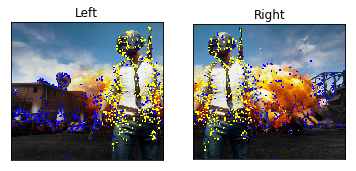

In [18]:
###########################################   PART 3   ########################################### 
#Perform RANSAC
threshold = 3
inlier = 0
max_inlier = 0
min_attempt = 200
curr_attempt = 0
inliers_sufficient = 1

src_inlier_set = []
dst_inlier_set = []
src_outlier_set = []
dst_outlier_set = []
src_max_inlier_set = []
dst_max_inlier_set = []

#convert keypoints from each image into "numpy.ndarray"
src_pts = np.float32([ kp_left[m.queryIdx].pt for m in matched ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_right[m.trainIdx].pt for m in matched ]).reshape(-1,1,2)

# for i in range(0, attempt):
while inliers_sufficient == 1:
    curr_attempt = curr_attempt + 1
    
    #generate 4 "random" sets of keypoints (4 for left, 4 for right)
    random = np.random.randint(0, len(src_pts))
    ptl1 = src_pts[random]
    ptr1 = dst_pts[random]
    random = np.random.randint(0, len(src_pts))
    ptl2 = src_pts[random]
    ptr2 = dst_pts[random] 
    random = np.random.randint(0, len(src_pts))
    ptl3 = src_pts[random]
    ptr3 = dst_pts[random] 
    random = np.random.randint(0, len(src_pts))
    ptl4 = src_pts[random] 
    ptr4 = dst_pts[random] 

    #place each of the 4 sets into 2 arrays 
    array1 = np.array([(ptl1), (ptl2), (ptl3), (ptl4)])
    array2 = np.array([(ptr1), (ptr2), (ptr3), (ptr4)])

    #generate homography via array formed above
    M, mask = cv2.findHomography(array1, array2, 0)

    for i in range(0, len(matched)):
        #select points from matched keypoints
        array_temp = np.array([(src_pts[i].item(0)), (src_pts[i].item(1)), (1)])
        #dot product of homography and [x, y, 1] with x and y being location of src_pts[i]
        pt_shud_be = M.dot(array_temp)
        #calculate the distance between point on homography modified img1 and corresponding point on img2
        dist = ((pt_shud_be.item(0)-(dst_pts[i].item(0)))**2 + (pt_shud_be.item(1)-(dst_pts[i].item(1)))**2)**0.5
        
        #inlier found
        if dist < threshold:
            inlier = inlier + 1
            #store the inlier into array
            src_inlier_set.append(src_pts[i])
            dst_inlier_set.append(dst_pts[i])
        else:
            #store the outlier into array
            src_outlier_set.append(src_pts[i])
            dst_outlier_set.append(dst_pts[i])
    
    #better result found as there are more inliers found than previous attempt
    if max_inlier < inlier:
        #update the current max_inlier
        max_inlier = inlier
        #save the inlier set
        src_max_inlier_set = src_inlier_set
        dst_max_inlier_set = dst_inlier_set
        #save the outlier set 
        src_max_outlier_set = src_outlier_set
        dst_max_outlier_set = dst_outlier_set
        #save the homography applied
        H = M
        
    #reset the current inlier/outlier set and repeat above procedure  
    inlier = 0
    src_inlier_set = []
    dst_inlier_set = []
    src_outlier_set = []
    dst_outlier_set = []
    
    #the loop will end once the program has ran a pre-defined number AND has found at least 8 inliers
    if curr_attempt >= min_attempt and max_inlier >= 8 :
        inliers_sufficient = 0

#circle the inliers yellow and outliers blue.
for n in range(0, len(src_max_inlier_set)):
    cv2.circle(q2_img2_right, (int(dst_max_inlier_set[n].item(0)), int(dst_max_inlier_set[n].item(1))), 3, (0, 255, 255), -1)
    cv2.circle(q2_img2_left, (int(src_max_inlier_set[n].item(0)), int(src_max_inlier_set[n].item(1))), 3, (0, 255, 255), -1)
    cv2.circle(q2_img2_right, (int(dst_max_outlier_set[n].item(0)), int(dst_max_outlier_set[n].item(1))), 3, (255, 0, 0), -1)
    cv2.circle(q2_img2_left, (int(src_max_outlier_set[n].item(0)), int(src_max_outlier_set[n].item(1))), 3, (255, 0, 0), -1)
    
#saving the output image to destination
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_part3_RANSAC_left.jpg', q2_img2_left)
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_part3_RANSAC_right.jpg', q2_img2_right)

#convert from BGR to RGB for displaying
q2_img2_left = cv2.cvtColor(q2_img2_left, cv2.COLOR_BGR2RGB)
q2_img2_right = cv2.cvtColor(q2_img2_right, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(q2_img2_left, cmap="gray")
plt.title("Left"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(q2_img2_right, cmap="gray")
plt.title("Right"), plt.xticks([]), plt.yticks([])
plt.show()

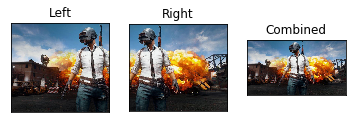

In [19]:
###########################################   PART 4 & 5   ########################################### 

#determine the dimensions of the two given image: left and right
left_height, left_width = q2_img1_left.shape[:2]
right_height, right_width = q2_img1_right.shape[:2]

#define the four corners of each image and place them into corresponding array
left_corners = np.float32([[0,0], [0,left_height], [left_width,left_height], [left_width,0]]).reshape(-1,1,2)
right_corners = np.float32([[0,0], [0,right_height], [right_width,right_height], [right_width,0]]).reshape(-1,1,2)

#determine the new image size by selecting the max and min point after concatenating all corners into one array
warped_left = cv2.perspectiveTransform(left_corners, H)
pano_corners = np.concatenate((right_corners, warped_left), axis=0)
[x_min, y_min] = np.int32(pano_corners.min(axis=0).ravel())
[x_max, y_max] = np.int32(pano_corners.max(axis=0).ravel())
H_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0,0,1]])

#Warp the image
pano_img = cv2.warpPerspective(q2_img1_left, H_translation.dot(H), (x_max - x_min, y_max - y_min))
#Fill the rest of the image by combining the other image
pano_img[-y_min: right_height + -y_min, -x_min:right_width + -x_min] = q2_img1_right
    
#saving the output image to destination
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_final_left.jpg', q2_img1_left)
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_final_right.jpg', q2_img1_right)
cv2.imwrite('/Users/Will/Desktop/Assign2/q2_final_panorama.jpg', pano_img)
    
# convert from BGR to RGB for displaying
pano_img = cv2.cvtColor(pano_img, cv2.COLOR_BGR2RGB)
q2_img1_left = cv2.cvtColor(q2_img1_left, cv2.COLOR_BGR2RGB)
q2_img1_right = cv2.cvtColor(q2_img1_right, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(131), plt.imshow(q2_img1_left, cmap="gray")
plt.title("Left"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(q2_img1_right, cmap="gray")
plt.title("Right"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(pano_img, cmap="gray")
plt.title("Combined"), plt.xticks([]), plt.yticks([])
plt.show()

In [1]:
###########################################   PART 6   ########################################### 

#Personally, I did not noticied any artifacts in the resulting image, perhaps
# this is due to the fact that my image isn't very large and kinda blurr if you
# zooom in.